In [2]:
import re
import random
data_path = "Data/English.txt"
data_path2 = "Data/Hindi.txt"
# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().strip().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().strip().split('\n')

lines = [" ".join(re.findall(r"[A-Za-z0-9]+",line)) for line in lines]
lines2 = [re.sub(r"%s|\(|\)|<|>|%|[a-z]|[A-Z]|_",'',line) for line in lines2]

# Grouping lines by response pair
pairs = list(zip(lines,lines2))
random.shuffle(pairs)
print(len(pairs))

10000


In [3]:
print(pairs[103])

('her least favorite animals were mice', 'उसके कम से कम पसंदीदा जानवर चूहे थे।')


In [4]:
import numpy as np

input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()
for line in pairs:
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
#   target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split(" "):
    if token not in target_tokens:
      target_tokens.add(token)
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())


max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.


In [5]:
print(target_docs[103],input_docs[103],num_decoder_tokens,num_encoder_tokens)

<START> उसके कम से कम पसंदीदा जानवर चूहे थे। <END> her least favorite animals were mice 678 200


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model
#Dimensionality
dimensionality = 256
#The batch size and number of epochs
batch_size = 256
epochs = 40
#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]
#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# #Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# #Compiling
training_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training
# history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
# training_model.save('Data/training_model.h5')

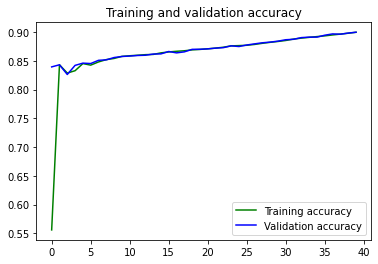

<Figure size 432x288 with 0 Axes>

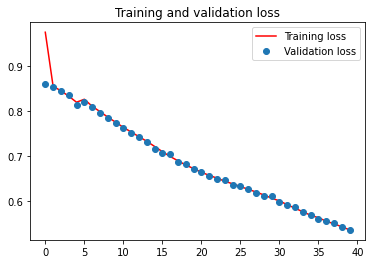

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('wordA.png')
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('wordL.png')
plt.figure()
plt.show()

In [7]:
from tensorflow import keras
from keras.models import load_model
from keras.layers import Input, LSTM, Dense
from keras.models import Model
training_model = load_model('Data/training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
      #Predicting output tokens with probabilities and states
      output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
#Choosing the one with highest probability
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      decoded_sentence += " " + sampled_token
#Stop if hit max length or found the stop token
      if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
        stop_condition = True
#Update the target sequence
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.
      #Update states
      states_value = [hidden_state, cell_state]
    return decoded_sentence

## Speech recognition

In [10]:
import random
import time

import speech_recognition as sr


def recognize_speech_from_mic(recognizer, microphone):
    """Transcribe speech recorded from `microphone`.
    Returns a dictionary with three keys:
    "success": a boolean indicating whether or not the API request was
               successful
    "error":   `None` if no error occured, otherwise a string containing
               an error message if the API could not be reached or
               speech was unrecognizable
    "transcription": `None` if speech could not be transcribed,
               otherwise a string containing the transcribed text
    """
    # check that recognizer and microphone arguments are appropriate type
    if not isinstance(recognizer, sr.Recognizer):
        raise TypeError("`recognizer` must be `Recognizer` instance")

    if not isinstance(microphone, sr.Microphone):
        raise TypeError("`microphone` must be `Microphone` instance")

    # adjust the recognizer sensitivity to ambient noise and record audio
    # from the microphone
    with microphone as source:
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

    # set up the response object
    response = {
        "success": True,
        "error": None,
        "transcription": None
    }

    # try recognizing the speech in the recording
    # if a RequestError or UnknownValueError exception is caught,
    #     update the response object accordingly
    try:
        response["transcription"] = recognizer.recognize_google(audio)
    except sr.RequestError:
        # API was unreachable or unresponsive
        response["success"] = False
        response["error"] = "API unavailable"
    except sr.UnknownValueError:
        # speech was unintelligible
        response["error"] = "Unable to recognize speech"

    return response


def eng_speak():
    # create recognizer and mic instances
    recognizer = sr.Recognizer()
    microphone = sr.Microphone()

    print("Speak in English and I will try to translate it into Hindi as per my best knowledge!\n")
    time.sleep(3)
    
    # get the guess from the user
    # if a transcription is returned, break out of the loop and
    #     continue
    # if no transcription returned and API request failed, break
    #     loop and continue
    # if API request succeeded but no transcription was returned,
    #     re-prompt the user to say their guess again. Do this up
    #     to PROMPT_LIMIT times
    PROMPT_LIMIT = 1
    for j in range(PROMPT_LIMIT):
        print('Speak!')
        guess = recognize_speech_from_mic(recognizer, microphone)
        if guess["transcription"]:
            break
        if not guess["success"]:
            break
        print("I didn't catch that. What did you say?\n")

        # if there was an error, stop the game
        if guess["error"]:
            print("ERROR: {}".format(guess["error"]))
            break

    # show the user the transcription
    print("You said: {}".format(guess["transcription"]))

    # determine if guess is correct and if any attempts remain
    eng_statement = guess["transcription"]
    return eng_statement

In [ ]:
import pyttsx3
import argparse
import traceback
import sys

# Default values
def talk(text_to_read):
    gender = "male"
    language = "hindi"
    accent = "indian"

    # if text args passed in cli
    if text_to_read:
        text_to_read = text_to_read

    # if language args passed in cli
    if language:
        language = language
        if language == "hindi":
            accent = "indian"

    # if accent args passed in cli
    if accent:
        accent = accent

    # if gender args passed in cli
    if gender:
        gender = gender

    # filters the languages and accents
    def filter_rule(voice, gender, language, accent, default):
        if default:
            return voice.gender in gender and voice.languages[0] == (language + '_' + accent)
        return voice.languages[0] == (language + '_' + accent) or voice.name in ["default", "Alex"]


    # Filtering voices based on given critaria
    def filter_voice(voices, gender, language, accent, default=True):
        filter_list = [voice for voice in voices if filter_rule(
            voice, gender, language, accent, default)]
        if len(filter_list):
            return filter_list
        return filter_voice(voices, gender, language, accent, False)


    # update reader's language, accent and gender
    def update_language(reader, language, accent, gender):
        # Audio Type Selection Criteria
        languages = {"english": "en", "hindi": "hi"}
        genders = {"male": ["VoiceGenderMale", "male"], "female": ["VoiceGenderFemale", "female"], "none": ["None"]}
        accents = {"indian": "IN", "us": "US", "australian": "AU", "uk": "GB"}

        # getting list of filtered voices based on selection criteria
        filtered_voice_list = filter_voice(reader.getProperty(
            'voices'), genders[gender], languages[language], accents[accent])

        if len(filtered_voice_list):
            # Displaying the details of filtered voices
            print("AVAILABLE READERS")
            for index, voice in enumerate(filtered_voice_list):
                print("\nVoice Index : %d" % index)
                print("ID: %s" % voice.id)
                print("Name: %s" % voice.name)
                print("Age: %s" % voice.age)
                print("Gender: %s" % voice.gender)
                print("Languages Known: %s" % voice.languages)

            index = 0
            try:
                if index and filtered_voice_list[int(index)]:
                    index = int(index)
            except IndexError:
                pass

            print("\n%s is reading for you." % filtered_voice_list[index].name)
            # applying the voice of selected reader
        reader.setProperty('voice', filtered_voice_list[1].id)
    #     else:
    #         print("No reader available.\nAlex is reading for you.")


    try:
        # initialize the reading engine
        reader = pyttsx3.init()

        # updating readers language, accent and gender before reading text.
        update_language(reader, language, accent, gender)

        # read the given text
        reader.say(text_to_read)

        # Execution of reading process
        reader.runAndWait()

        # Finish the reading process
        reader.stop()

    except OSError as error:
        traceback.print_exception(*sys.exc_info())
        print("There is a chance that some required system lib is missing, install the lib and try again")

    except Exception as error:
        traceback.print_exception(*sys.exc_info())
        print("Someting went wrong; please report the issue at https://github.com/vishalnagda1/text-to-speech/issues")

In [8]:
class Translator:
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the translator
  def start(self):
    user_response = eng_speak()
    self.translate(user_response)
  
  #Method to handle the conversation
  def translate(self, reply):
    while not self.make_exit(reply):
      talk(self.generate_response(reply)+"\n")
      reply = eng_speak()
    

  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
translator = Translator()

In [9]:
translator.start()

Give in an English sentence. :) 
 he likes banana


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

 रात रात रात रात रात अगली अगली अगली अगली अगली अगली अगली अगली हिमयुग हिमयुग हिमयुग हिमयुग
 she likes peach
 रात रात रात रात रात अगली अगली अगली अगली अगली अगली अगली अगली हिमयुग हिमयुग हिमयुग हिमयुग
 hello
 रात रात बहुत बहुत बहुत अगली अगली अगली अगली अगली अगली अगली अगली हिमयुग हिमयुग हिमयुग हिमयुग
 bye


Ok, have a great day!
